In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

import random
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from keras.layers import Dense, merge, GlobalAveragePooling2D
import keras
from keras.models import Model

from keras.applications.resnet50 import ResNet50
from keras.layers import Input

Using TensorFlow backend.


In [2]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [3]:
slide_test1 = open_slide('/home/wenshen2543/slide_data/tumor_110.tif')
tumor_mask_test1 = open_slide('/home/wenshen2543/slide_data/tumor_110_mask.tif')
slide_test_image1 = read_slide(slide_test1, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide_test1.level_dimensions[5][0], 
                         height=slide_test1.level_dimensions[5][1])
tumor_mask_test_image1 = read_slide(tumor_mask_test1, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=tumor_mask_test1.level_dimensions[5][0], 
                         height=tumor_mask_test1.level_dimensions[5][1])
tumor_mask_test_image1 = tumor_mask_test_image1[:,:,0]

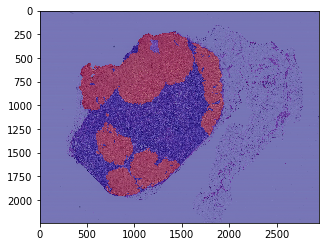

In [4]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_test_image1)
plt.imshow(tumor_mask_test_image1, cmap='jet', alpha=0.5)

In [5]:
slide_test2 = open_slide('/home/wenshen2543/slide_data/tumor_078.tif')
tumor_mask_test2 = open_slide('/home/wenshen2543/slide_data/tumor_078_mask.tif')
slide_test_image2 = read_slide(slide_test2, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide_test2.level_dimensions[5][0], 
                         height=slide_test2.level_dimensions[5][1])
tumor_mask_test_image2 = read_slide(tumor_mask_test2, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=tumor_mask_test2.level_dimensions[5][0], 
                         height=tumor_mask_test2.level_dimensions[5][1])
tumor_mask_test_image2 = tumor_mask_test_image2[:,:,0]

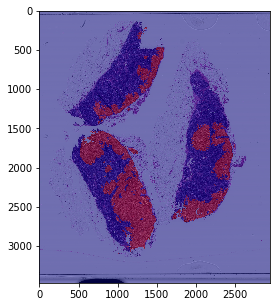

In [6]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_test_image2)
plt.imshow(tumor_mask_test_image2, cmap='jet', alpha=0.5)

In [7]:
slide_test3 = open_slide('/home/wenshen2543/slide_data/tumor_005.tif')
tumor_mask_test3 = open_slide('/home/wenshen2543/slide_data/tumor_005_mask.tif')
slide_test_image3 = read_slide(slide_test3, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide_test3.level_dimensions[5][0], 
                         height=slide_test3.level_dimensions[5][1])
tumor_mask_test_image3 = read_slide(tumor_mask_test3, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=tumor_mask_test3.level_dimensions[5][0], 
                         height=tumor_mask_test3.level_dimensions[5][1])
tumor_mask_test_image3 = tumor_mask_test_image3[:,:,0]

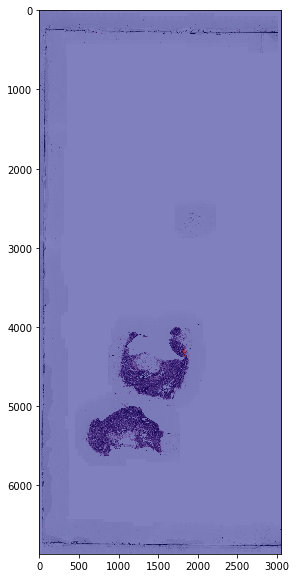

In [8]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_test_image3)
plt.imshow(tumor_mask_test_image3, cmap='jet', alpha=0.5)

In [9]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])


def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [10]:
def get_center_and_labels(slide_image_base, mask_image_base, downsample_factor, level):
    step = 84
    w = 84  
    labels = []
    
    width_bound = slide_image_base.level_dimensions[level][0]
    height_bound = slide_image_base.level_dimensions[level][1]
    
    center = []
  
    for j in range(0,height_bound,step):
        for i in range(0,width_bound,step):
            region = read_slide(mask_image_base, x= i * downsample_factor, y= j * downsample_factor, level= level, width=w, height=w)[:,:,0] 
            interest_region = read_slide(slide_image_base, x= i * downsample_factor, y= j * downsample_factor, level= level, width=w, height=w)
      
            tissue_pixels = find_tissue_pixels(interest_region)
            percent_tissue = len(list(tissue_pixels)) / float(interest_region.shape[0] * interest_region.shape[0])
            if percent_tissue > 0.1:
                center.append((int(i + w/2), int(j + w/2)))
                label = 1 if region.sum()>0 else 0
                labels.append(label)
    return center, labels

In [11]:
def get_center_and_labels_for_test(slide_image_base, mask_image_base, downsample_factor, level):
    step = 84
    w = 84  
    labels = []
  
    width_bound = slide_image_base.level_dimensions[level][0]
    height_bound = slide_image_base.level_dimensions[level][1]
  
    center = []
  
    for j in range(0,height_bound,step):
        for i in range(0,width_bound,step):
            region = read_slide(mask_image_base, x= i * downsample_factor, y= j * downsample_factor, level= level, width=w, height=w)[:,:,0] 
            interest_region = read_slide(slide_image_base, x= i * downsample_factor, y= j * downsample_factor, level= level, width=w, height=w)
      
            center.append((int(i + w/2), int(j + w/2)))
            
            label = 1 if region.sum()>0 else 0
            labels.append(label)
    return center, labels

In [12]:
def get_basepatches(center, slide_image_base, base_level, base_downsample_factor):
    w = 139
    base_patches = []
    
    for (i,j) in center:
        topleft_basei = int(i-w/2)
        topleft_basej = int(j-w/2)
    
   
        region_base = np.array(read_slide(slide_image_base, x= topleft_basei * base_downsample_factor, y= topleft_basej * base_downsample_factor, level= base_level, width=w, height=w))
    
    
        if topleft_basei < 0:
            region_base[:,0:(-topleft_basei),:] = 255
    
        if topleft_basei + w > slide_image_base.level_dimensions[base_level][0]:
            region_base[:,-(topleft_basei + w - slide_image_base.level_dimensions[base_level][0]):,:] =255
    
        if topleft_basej < 0:
            region_base[0:(-topleft_basej),:,:] = 255
     
        if topleft_basej + w > slide_image_base.level_dimensions[base_level][1]:
            region_base[-(topleft_basej + w - slide_image_base.level_dimensions[base_level][1]):,:,:] = 255
            
    
        base_patches.append(region_base)
    
    return base_patches

In [13]:
def get_patches(center, slide_image_base, base_level, downsample_factor, level):
    w = 139
    patches = []
  
    for (i,j) in center:
        new_i = i * 1.0 / slide_image_base.level_dimensions[base_level][0] * slide_image_base.level_dimensions[level][0]
        new_j = j * 1.0 / slide_image_base.level_dimensions[base_level][1] * slide_image_base.level_dimensions[level][1]
    
        topleft_i = int(new_i - w/2)
        topleft_j = int(new_j - w/2)
    
    
        region = np.array(read_slide(slide_image_base, x= topleft_i * downsample_factor, y= topleft_j * downsample_factor, level= level, width=w, height=w))
    
        if topleft_i < 0:
            region[:,0:(-topleft_i),:] = 255
    
        if topleft_i + w > slide_image_base.level_dimensions[level][0]:
            region[:,-(topleft_i + w - slide_image_base.level_dimensions[level][0]):,:] = 255
    
        if topleft_j < 0:
            region[0:(-topleft_j),:,:] = 255
     
        if topleft_j + w > slide_image_base.level_dimensions[level][1]:
            region[-(topleft_j + w - slide_image_base.level_dimensions[level][1]):,:,:] = 255
        
        patches.append(region)
    return patches

In [14]:
x_train1 = []
x_train2 = []

y_train = []

for i in ["091","084","101","001","016","019","023","031","057","064","081","075","096"]:
    slide_path = "/home/wenshen2543/slide_data/" + "tumor_"+ i + ".tif"
    tumor_mask_path = "/home/wenshen2543/slide_data/" + "tumor_"+ i + "_mask.tif"

    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)
  
    center,labels = get_center_and_labels(slide_image_base=slide, mask_image_base=tumor_mask, downsample_factor=8, level=3)
    
    base_patches = get_basepatches(center, slide_image_base=slide, base_level=3, base_downsample_factor=8)
    print("=> base_patches for Slide", i, "done successfully!")
    patches1 = get_patches(center, slide_image_base=slide, base_level=3, downsample_factor=16, level=4)
    print("=> patches1 for Slide", i, "done successfully!")
  
    x_train1 += base_patches
  
    x_train2 += patches1
  
    y_train += labels
  
    print("Get patches on Slide", i, "successfully!")

=> base_patches for Slide 091 done successfully!
=> patches1 for Slide 091 done successfully!
Get patches on Slide 091 successfully!
=> base_patches for Slide 084 done successfully!
=> patches1 for Slide 084 done successfully!
Get patches on Slide 084 successfully!
=> base_patches for Slide 101 done successfully!
=> patches1 for Slide 101 done successfully!
Get patches on Slide 101 successfully!
=> base_patches for Slide 001 done successfully!
=> patches1 for Slide 001 done successfully!
Get patches on Slide 001 successfully!
=> base_patches for Slide 016 done successfully!
=> patches1 for Slide 016 done successfully!
Get patches on Slide 016 successfully!
=> base_patches for Slide 019 done successfully!
=> patches1 for Slide 019 done successfully!
Get patches on Slide 019 successfully!
=> base_patches for Slide 023 done successfully!
=> patches1 for Slide 023 done successfully!
Get patches on Slide 023 successfully!
=> base_patches for Slide 031 done successfully!
=> patches1 for Slid

In [29]:
print(len(x_train1),len(x_train2),len(y_train))

62370 62370 62370


In [30]:
print(len(x_train1),len(x_train2),len(y_train))

62370 62370 62370


In [15]:
x_test1 = []
x_test2 = []
y_test = []

for i in ["078","110","005"]:
    slide_path = "/home/wenshen2543/slide_data/"+"tumor_"+ i + ".tif"
    tumor_mask_path = "/home/wenshen2543/slide_data/"+"tumor_"+ i + "_mask.tif"

    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)
  
    center,labels = get_center_and_labels_for_test(slide_image_base=slide, mask_image_base=tumor_mask, downsample_factor=8, level=3)
    base_patches = get_basepatches(center, slide_image_base=slide, base_level=3, base_downsample_factor=8)
    print("=> base_patches for Slide", i, "done successfully!")
    patches1 = get_patches(center, slide_image_base=slide, base_level=3, downsample_factor=16, level=4)
    print("=> patches1 for Slide", i, "done successfully!")
  
    x_test1 += base_patches
    x_test2 += patches1
  
    y_test += labels
  
    print("Get patches on Slide", i, "successfully!")
    print("Count:", len(y_test))

# 23406
# 15087
# 47742

=> base_patches for Slide 078 done successfully!
=> patches1 for Slide 078 done successfully!
Get patches on Slide 078 successfully!
Count: 23406
=> base_patches for Slide 110 done successfully!
=> patches1 for Slide 110 done successfully!
Get patches on Slide 110 successfully!
Count: 38493
=> base_patches for Slide 005 done successfully!
=> patches1 for Slide 005 done successfully!
Get patches on Slide 005 successfully!
Count: 86235


In [16]:
import random
def oversampling(x_train1, x_train2, y_train):
    sample_num = int(len(y_train) - sum(y_train))
    
    indices = [i for i, x in enumerate(y_train) if x == 1]
    more = [i for i, x in enumerate(y_train) if x == 0]
    
    oversample = [random.choice(indices) for _ in range(sample_num)]
    
    X1 = []
    X2 = []
    y = []
    for i in oversample:
        X1.append(x_train1[i])
        X2.append(x_train2[i])
        y.append(y_train[i])
    for i in more:
        X1.append(x_train1[i])
        X2.append(x_train2[i])
        y.append(y_train[i])
    
    X1, X2, y = shuffle(X1, X2, y, random_state=42)
    print('The final label 1 (tumor) percent to check if dataset is balance: {}%'.format(sum(y)*1.0*100/len(y)))
  
    return X1, X2, y

In [17]:
def undersampling(x_train1, x_train2, y_train):
    sample_num = int(sum(y_train))
    
    indices = [i for i, x in enumerate(y_train) if x == 0]
    more = [i for i, x in enumerate(y_train) if x == 1]
    
    oversample = [random.choice(indices) for _ in range(sample_num)]
    
    X1 = []
    X2 = []
    y = []
    for i in oversample:
        X1.append(x_train1[i])
        X2.append(x_train2[i])
        y.append(y_train[i])
    for i in more:
        X1.append(x_train1[i])
        X2.append(x_train2[i])
        y.append(y_train[i])
    
    X1, X2, y = shuffle(X1, X2, y, random_state=42)
    print('The final label 1 (tumor) percent to check if dataset is balance: {}%'.format(sum(y)*1.0*100/len(y)))
  
    return X1, X2, y

In [18]:
X_train1_over, X_train2_over, y_train_over = oversampling(x_train1, x_train2, y_train)
print(len(X_train1_over),len(X_train2_over),len(y_train_over))

The final label 1 (tumor) percent to check if dataset is balance: 50.0%
118986 118986 118986


In [19]:
from keras.applications.inception_v3 import InceptionV3
def My_FusionModel4(X_train1, X_train2, y_train, X_test1, X_test2, y_test):
    model1 = InceptionV3(include_top=False, weights='imagenet',input_shape=(139, 139, 3))
    for layer in model1.layers:
        layer.trainable = False
    
    inp = model1.input
    out = model1.output

    model2 = InceptionV3(include_top=False, weights='imagenet',input_shape=(139, 139, 3))
    for layer in model2.layers:
        layer.name = layer.name + str("_2")
        layer.trainable = False

    inp2 = model2.input
    out2 = model2.output

    merged = merge([out, out2],mode='concat')
  
    merged = GlobalAveragePooling2D()(merged)

    merged = Dense(1024, activation='relu')(merged)
    merged = Dense(1, activation='sigmoid')(merged)

    model_fusion = Model([inp, inp2], merged)
  
    model_fusion.compile(loss='binary_crossentropy',
              optimizer=tf.train.AdamOptimizer(),
              metrics=['acc'])
  
    model_fusion.summary()
    
    from sklearn.model_selection import train_test_split
    X_train1_shuffle, X_val1_shuffle, X_train2_shuffle, X_val2_shuffle, Y_train_shuffle, Y_val_shuffle = train_test_split(X_train1, X_train2, y_train, test_size=0.1, random_state=42, shuffle=True)
  
    history5 = model_fusion.fit([X_train1_shuffle, X_train2_shuffle], Y_train_shuffle, validation_data=([X_val1_shuffle, X_val2_shuffle],Y_val_shuffle),nb_epoch=10, batch_size=32)
  
    scores = model_fusion.evaluate([X_test1, X_test2], y_test)
  
    y_predict = model_fusion.predict([X_test1, X_test2])
    y_predict_prob = y_predict
  
    y_predict_label = np.array([0]*len(y_test))
    y_predict_label[(np.where(y_predict_prob>=0.5)[0])] = 1

  
    print(y_predict_label.shape)
    print('Loss (Two-scale Model):', scores[0])
    print('Accuracy (Two-scale Model):', scores[1])
    print('Precision (Two-scale Model):', precision_score(y_test,y_predict_label))
    print('Recall (Two-scale Model):', recall_score(y_test,y_predict_label))
    print('F1 (Two-scale Model):', f1_score(y_test,y_predict_label))
    print('ROCAUC (Two-scale Model):', roc_auc_score(y_test,y_predict_label))
    print('Confusion Matrix (Two-scale Model):\n', confusion_matrix(y_test,y_predict_label))
  
    return model_fusion, y_predict_label, y_predict_prob, history5

In [20]:
model_Incep, y_predict_label_Incep, y_predict_prob_Incep, history5 = My_FusionModel4(np.asarray(X_train1_over), np.asarray(X_train2_over), np.asarray(y_train_over),np.asarray(x_test1),np.asarray(x_test2),np.asarray(y_test))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 139, 139, 3)   0                                            
____________________________________________________________________________________________________
input_2_2 (InputLayer)           (None, 139, 139, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 69, 69, 32)    896         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_95_2 (Convolution2 (None, 69, 69, 32)    896         input_2_2[0][0]                  
___________________________________________________________________________________________

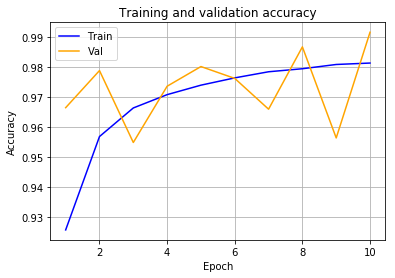

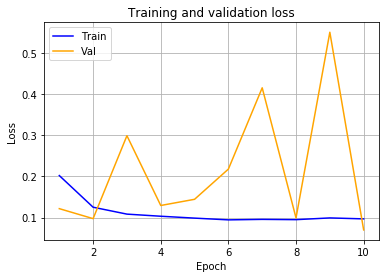

In [21]:
acc = history5.history['acc']
val_acc = history5.history['val_acc']
loss = history5.history['loss']
val_loss = history5.history['val_loss']

# Get the number of epochs
epochs = range(1,len(acc)+1)

plt.title('Training and validation accuracy')
plt.grid()
plt.plot(epochs, acc, color='blue', label='Train')
plt.plot(epochs, val_acc, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.grid()
plt.plot(epochs, loss, color='blue', label='Train')
plt.plot(epochs, val_loss, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [23]:
#from PIL import Image
from PIL import Image
# 110 slide
test1 = Image.fromarray(slide_test_image1.astype('uint8'), 'RGB')
test1 = test1.resize((141,107), Image.ANTIALIAS)

# 078 slide
test2 = Image.fromarray(slide_test_image2.astype('uint8'), 'RGB')
test2 = test2.resize((141,166), Image.ANTIALIAS)

# 005 slide
test3 = Image.fromarray(slide_test_image3.astype('uint8'), 'RGB')
test3 = test3.resize((146,327), Image.ANTIALIAS)

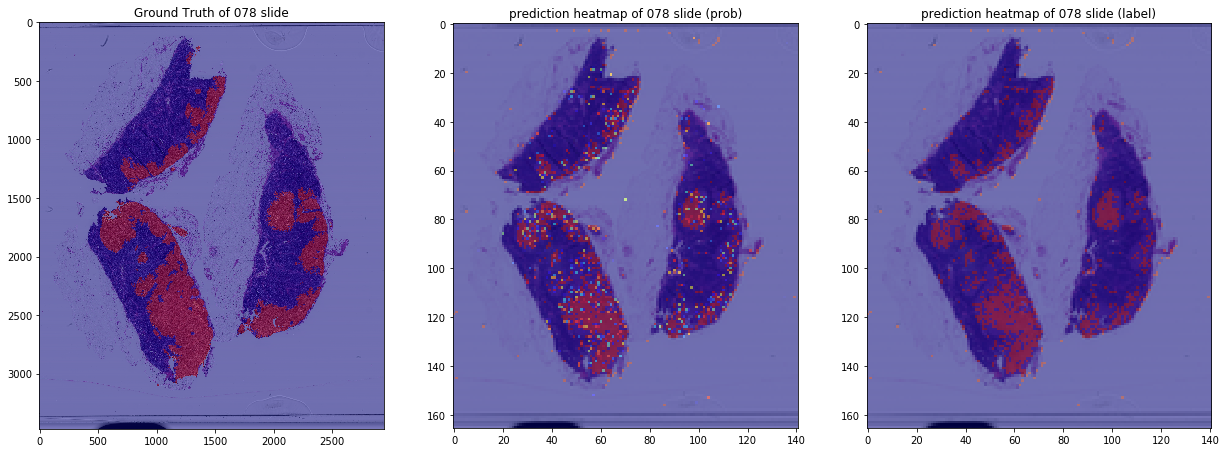

In [24]:
# Ground Truth of 078 slide
plt.figure(figsize=(21,21), dpi=100)
plt.subplot(1,3,1)
plt.title("Ground Truth of 078 slide")
plt.imshow(slide_test_image2)
plt.imshow(tumor_mask_test_image2, cmap='jet', alpha=0.5)

# prediction of probability heatmap of 078 slide
plt.subplot(1,3,2)
plt.title("prediction heatmap of 078 slide (prob)")
prob_image2 = np.reshape(y_predict_prob_Incep[0:23406],(-1,141))
plt.imshow(test2)
plt.imshow(prob_image2 , cmap='jet',alpha=0.5)

# prediction of label heatmap of 078 slide
plt.subplot(1,3,3)
plt.title("prediction heatmap of 078 slide (label)")
label_image2 = np.reshape(y_predict_label_Incep[0:23406],(-1,141))
plt.imshow(test2)
plt.imshow(label_image2 , cmap='jet',alpha=0.5)

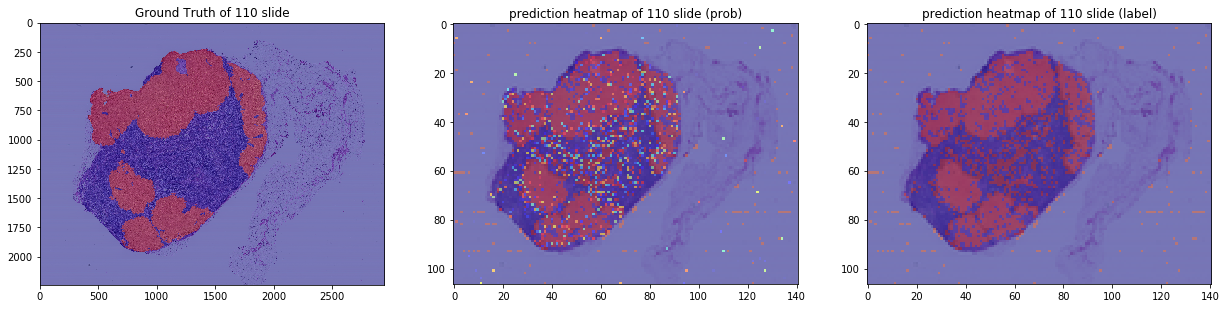

In [25]:
# Ground Truth of 110 slide
plt.figure(figsize=(21,21), dpi=100)
plt.subplot(1,3,1)
plt.title("Ground Truth of 110 slide")
plt.imshow(slide_test_image1)
plt.imshow(tumor_mask_test_image1, cmap='jet', alpha=0.5)

# prediction of probability heatmap of 110 slide
plt.subplot(1,3,2)
plt.title("prediction heatmap of 110 slide (prob)")
prob_image1 = np.reshape(y_predict_prob_Incep[23406:38493],(-1,141))
plt.imshow(test1)
plt.imshow(prob_image1 , cmap='jet',alpha=0.5)

# prediction of label heatmap of 110 slide
plt.subplot(1,3,3)
plt.title("prediction heatmap of 110 slide (label)")
label_image1 = np.reshape(y_predict_label_Incep[23406:38493],(-1,141))
plt.imshow(test1)
plt.imshow(label_image1 , cmap='jet',alpha=0.5)

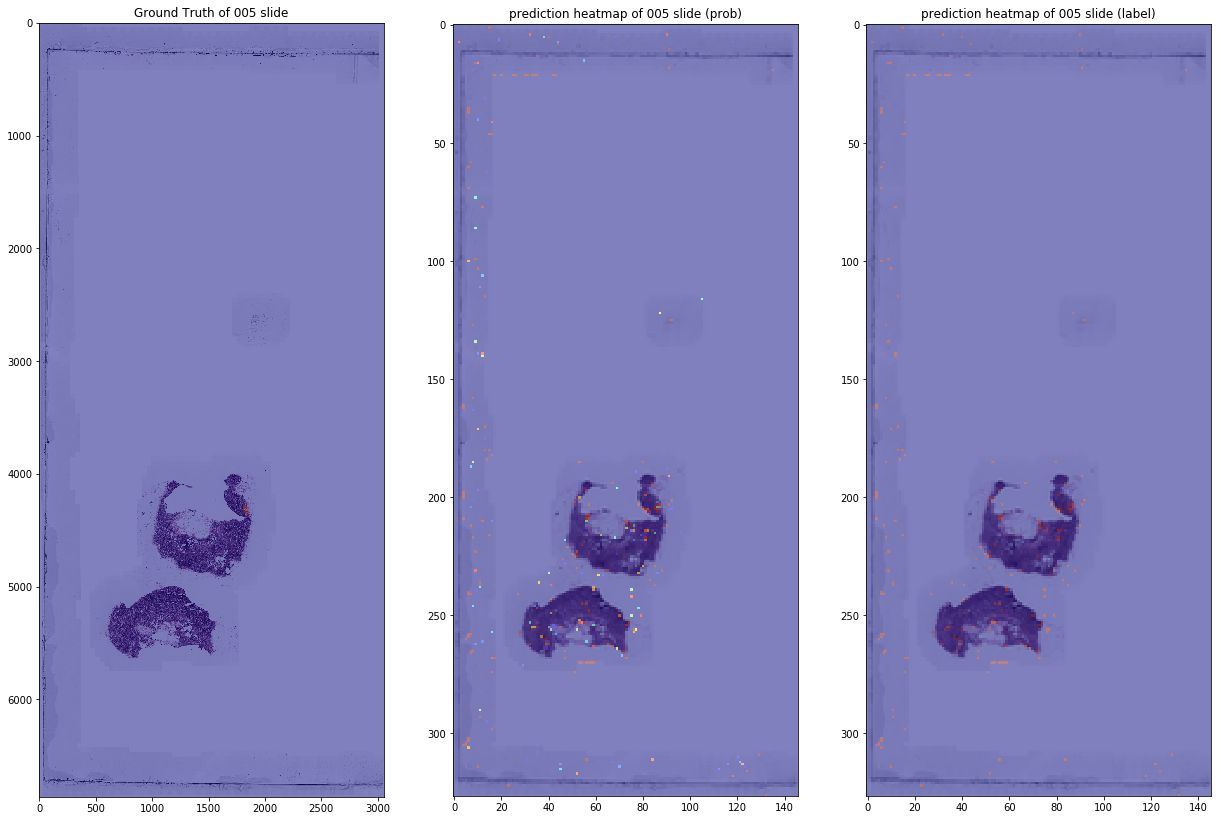

In [27]:
# Ground Truth of 005 slide
plt.figure(figsize=(21,21), dpi=100)
plt.subplot(1,3,1)
plt.title("Ground Truth of 005 slide")
plt.imshow(slide_test_image3)
plt.imshow(tumor_mask_test_image3, cmap='jet', alpha=0.5)

# prediction of probability heatmap of 005 slide
plt.subplot(1,3,2)
plt.title("prediction heatmap of 005 slide (prob)")
prob_image3 = np.reshape(y_predict_prob_Incep[38493:],(-1,146))
plt.imshow(test3)
plt.imshow(prob_image3 , cmap='jet',alpha=0.5)

# prediction of label heatmap of 005 slide
plt.subplot(1,3,3)
plt.title("prediction heatmap of 005 slide (label)")
label_image3 = np.reshape(y_predict_label_Incep[38493:],(-1,146))
plt.imshow(test3)
plt.imshow(label_image3 , cmap='jet',alpha=0.5)


In [28]:
model_Incep.save_weights('/home/wenshen2543/model/model_Incep_weights.h5')
model_Incep.save('/home/wenshen2543/model/model_Incep.h5')

/home/wenshen2543/anaconda3/lib/python3.5/site-packages/keras/models.py:61: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
